<a href="https://colab.research.google.com/github/lym0405/simple_homepage/blob/main/%EC%95%8C%EA%B3%A0%EB%A6%AC%EB%93%AC_%EA%B0%9C%EC%9D%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
pip install yfinance pandas matplotlib seaborn

In [32]:
import os, json
from datetime import datetime
import numpy as nd
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# 한 셀에서 실행: yfinance에서 다운로드(신세계 + S&P500) -> 안전히 Adj Close 추출 -> CSV 저장
import os
import pandas as pd
import numpy as np
import yfinance as yf

OUT_DIR = "./data"
os.makedirs(OUT_DIR, exist_ok=True)

tickers_map = {"SHINSEGAE": "004170.KS", "SP500": "^GSPC"}
START = "2024-08-29"
END   = "2025-08-29"

def safe_sanitize_dataframe(df):
    # flatten MultiIndex columns if any (join with underscore)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ["_".join([str(part) for part in col if part is not None and str(part)!='']) for col in df.columns]
        # e.g. "Adj Close_^GSPC", "Close_^GSPC", ...
    # Ensure datetime index
    try:
        df.index = pd.to_datetime(df.index)
    except Exception:
        df.index = pd.to_datetime(df.index.astype(str), errors='coerce')
    # Coerce numeric-ish columns to numeric (vectorized)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def get_adj_series_from_df(df, ticker_label):
    """
    Given a df returned by yfinance for a single ticker, return a 1-d pd.Series
    that is the adjusted close for that ticker.
    Ticker_label is the yahoo ticker (e.g. '^GSPC' or '004170.KS') or our friendly name.
    This function handles:
      - MultiIndex columns like ('Adj Close','^GSPC')
      - Flattened columns like 'Adj Close_^GSPC'
      - normal single-level columns 'Adj Close' or 'Close'
    """
    # 1) If MultiIndex originally (we didn't flatten yet), try tuple selection
    if isinstance(df.columns, pd.MultiIndex):
        # try exact tuple
        tup = ('Adj Close', ticker_label)
        if tup in df.columns:
            return df[tup].copy()
        # try ('Adj Close', ) slice
        try:
            adj_all = df.xs('Adj Close', axis=1, level=0)
            # adj_all may be Series (single ticker) or DataFrame (many tickers)
            if isinstance(adj_all, pd.Series):
                return adj_all.copy()
            # if DataFrame, try to find the column matching ticker_label
            for col in adj_all.columns:
                if str(col) == str(ticker_label) or str(col).endswith(str(ticker_label)):
                    return adj_all[col].copy()
            # else return first column (fallback)
            return adj_all.iloc[:,0].copy()
        except Exception:
            pass

    # 2) If columns flattened to 'Adj Close_^GSPC' or similar
    # construct candidates
    candidates = [
        f"Adj Close_{ticker_label}",
        f"Adj Close^{ticker_label}",
        f"AdjClose_{ticker_label}",
        f"Adj Close {ticker_label}",
        'Adj Close', 'adj close', 'adjclose', 'Close', 'close'
    ]
    for cand in candidates:
        if cand in df.columns:
            ser = df[cand]
            # if this is dataframe/object, try to coerce to series
            if isinstance(ser, pd.Series):
                return ser.copy()
            # if unexpected, try first column
            if isinstance(ser, pd.DataFrame):
                return ser.iloc[:,0].copy()

    # 3) As a last resort: try to find any column name that contains 'adj' and 'close'
    for c in df.columns:
        lc = str(c).lower()
        if 'adj' in lc and 'close' in lc:
            return df[c].copy()

    # 4) If nothing found, try 'Close'
    if 'Close' in df.columns:
        return df['Close'].copy()

    # If still nothing, raise to debug upstream
    raise KeyError("Could not find an Adj Close (or Close) series in this dataframe. Columns: " + ", ".join(map(str, df.columns[:20])))

# ---- Main loop: download each ticker, extract adj series, combine ----
adj_series_list = []
for friendly, tk in tickers_map.items():
    print("Downloading", friendly, tk)
    df = yf.download(tk, start=START, end=END, progress=False, auto_adjust=False)
    if df.empty:
        raise RuntimeError(f"No data for {tk}")
    # Keep a raw copy
    raw_path = os.path.join(OUT_DIR, f"{friendly}_raw.csv")
    # Save raw (safe sanitize before saving to make CSV readable)
    df_safe = safe_sanitize_dataframe(df.copy())
    df_safe.to_csv(raw_path)
    print("  saved raw:", raw_path)

    # Now attempt to get Adj Close series using robust function
    try:
        # Note: pass the Yahoo ticker when checking tuple keys; but friendly is used as column name later
        ser = get_adj_series_from_df(df, tk)
    except KeyError as e:
        # try again after flattening columns (for safety)
        df_flat = safe_sanitize_dataframe(df.copy())
        try:
            ser = get_adj_series_from_df(df_flat, tk)
        except Exception as e2:
            print("ERROR extracting Adj Close for", tk)
            print("df.columns:", df.columns)
            raise

    # rename the series to friendly name and append
    ser = ser.rename(friendly)
    adj_series_list.append(ser)

# Concatenate (align on dates), reindex to business days and forward-fill
adj_df = pd.concat(adj_series_list, axis=1)
bidx = pd.date_range(start=adj_df.index.min(), end=adj_df.index.max(), freq='B')
adj_df = adj_df.reindex(bidx).ffill()
adj_csv = os.path.join(OUT_DIR, "prices_adj.csv")
adj_df.to_csv(adj_csv)
print("Saved combined adj CSV:", adj_csv)
print(adj_df.info())
print(adj_df.head())


  saved raw: ./data/SHINSEGAE_raw.csv
  saved raw: ./data/SP500_raw.csv
Saved combined adj CSV: ./data/prices_adj.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2024-08-29 to 2025-08-28
Freq: B
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SHINSEGAE  261 non-null    float64
 1   SP500      261 non-null    float64
dtypes: float64(2)
memory usage: 6.1 KB
None
                SHINSEGAE        SP500
2024-08-29  145401.906250  5591.959961
2024-08-30  145983.515625  5648.399902
2024-09-02  148116.078125  5648.399902
2024-09-03  152284.265625  5528.930176
2024-09-04  147243.671875  5520.069824


In [43]:
# === Compute SMAs, detect MA crosses, plot, and save outputs ===
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

OUT = "./data"
os.makedirs(OUT, exist_ok=True)

# Use existing adj_df if in memory otherwise load from CSV
try:
    adj_df
except NameError:
    adj_df = pd.read_csv(os.path.join(OUT, "prices_adj.csv"), index_col=0, parse_dates=True)

# ensure DatetimeIndex and business-day reindex (safety)
if not isinstance(adj_df.index, pd.DatetimeIndex):
    adj_df.index = pd.to_datetime(adj_df.index)
bidx = pd.date_range(start=adj_df.index.min(), end=adj_df.index.max(), freq='B')
adj_df = adj_df.reindex(bidx).ffill()
adj_df = adj_df.loc[adj_df.index.min():adj_df.index.max()]  # keep full range

# 1) compute SMAs per column
windows = (5, 20, 60)
df_sma = adj_df.copy()
for col in adj_df.columns:
    for w in windows:
        df_sma[f"{col}_SMA_{w}"] = adj_df[col].rolling(window=w, min_periods=1).mean()

# save CSV with SMA
sma_path = os.path.join(OUT, "prices_with_sma.csv")
df_sma.to_csv(sma_path)
print("Saved:", sma_path)

# 2) helper: find crosses (returns lists of timestamps)
def find_crosses(series_short, series_long):
    diff = series_short - series_long
    sign = np.sign(diff)
    golden = series_short.index[(sign > 0) & (sign.shift(1) <= 0)]
    dead   = series_short.index[(sign < 0) & (sign.shift(1) >= 0)]
    return list(golden), list(dead)

# detect for SHINSEGAE: SMA_5 vs SMA_20 and SMA_20 vs SMA_60
stock = "SHINSEGAE"
g5_20, d5_20 = find_crosses(df_sma[f"{stock}_SMA_5"], df_sma[f"{stock}_SMA_20"])
g20_60, d20_60 = find_crosses(df_sma[f"{stock}_SMA_20"], df_sma[f"{stock}_SMA_60"])

# save crosses to CSV
rows = []
for d in g5_20:
    rows.append({"date": pd.to_datetime(d).date(), "type":"golden", "pair": f"{stock} 5/20"})
for d in d5_20:
    rows.append({"date": pd.to_datetime(d).date(), "type":"dead", "pair": f"{stock} 5/20"})
for d in g20_60:
    rows.append({"date": pd.to_datetime(d).date(), "type":"golden", "pair": f"{stock} 20/60"})
for d in d20_60:
    rows.append({"date": pd.to_datetime(d).date(), "type":"dead", "pair": f"{stock} 20/60"})

crosses_df = pd.DataFrame(rows).sort_values("date")
crosses_path = os.path.join(OUT, "ma_crosses_shinsegae.csv")
crosses_df.to_csv(crosses_path, index=False)
print("Saved:", crosses_path)

# 3) post-cross returns (horizons 10 & 20 business days)
def post_cross_returns(df, cross_dates, price_col, horizons=(10,20)):
    out_rows = []
    # normalize cross_dates to Timestamps
    tss = [pd.to_datetime(d) for d in cross_dates]
    for ts in tss:
        pos = df.index.searchsorted(ts)
        if pos >= len(df):
            continue
        start_idx = pos
        for h in horizons:
            end_idx = start_idx + h
            if end_idx < len(df):
                p0 = df[price_col].iloc[start_idx]
                p1 = df[price_col].iloc[end_idx]
                if pd.isna(p0) or pd.isna(p1):
                    continue
                ret = float(p1 / p0 - 1.0)
                out_rows.append({"cross_date": df.index[start_idx].date(), "horizon": h, "return": ret})
    if not out_rows:
        return pd.DataFrame(columns=["horizon","mean","std","count"])
    out = pd.DataFrame(out_rows)
    agg = out.groupby("horizon")["return"].agg(["mean","std","count"]).reset_index()
    return agg

golden_agg = post_cross_returns(df_sma, g5_20, price_col=stock, horizons=(10,20))
dead_agg   = post_cross_returns(df_sma, d5_20, price_col=stock, horizons=(10,20))
golden_agg.to_csv(os.path.join(OUT,"golden_post_returns_5_20.csv"), index=False)
dead_agg.to_csv(os.path.join(OUT,"dead_post_returns_5_20.csv"), index=False)
print("Saved post-cross return summaries (5/20).")

# 4) plotting (normalized, and price+SMA for stock)
def safe_plot_price_sma(df_with_sma, symbol_col, out_png):
    dates = df_with_sma.index
    date_nums = mdates.date2num(dates.to_pydatetime())
    # bar width scalar
    if len(date_nums) >= 2:
        bar_w = float(np.median(np.diff(date_nums))) * 0.6
    else:
        bar_w = 0.8

    fig, ax = plt.subplots(2,1, figsize=(11,7), gridspec_kw={"height_ratios":[3,1]}, sharex=True)
    ax0, ax1 = ax
    ax0.plot(dates, df_with_sma[symbol_col], label=f"{symbol_col}", linewidth=1.1)
    for w in windows:
        col_name = f"{symbol_col}_SMA_{w}"
        if col_name in df_with_sma.columns:
            ax0.plot(dates, df_with_sma[col_name], label=f"SMA {w}", linewidth=0.9)
    ax0.legend(loc="upper left", fontsize=8)
    ax0.grid(True, alpha=0.3)

    # no volume available in prices_adj; put placeholder text
    ax1.text(0.5, 0.5, "Volume not included in adj CSV", transform=ax1.transAxes, ha='center', va='center')
    ax1.set_ylabel("Volume")
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close(fig)
    print("Saved:", out_png)

# normalized comparison plot
norm = adj_df / adj_df.iloc[0] * 100
norm_png = os.path.join(OUT, "normalized_shinsegae_sp500.png")
fig, ax = plt.subplots(figsize=(11,5))
for c in norm.columns:
    ax.plot(norm.index, norm[c], label=c)
ax.legend()
ax.set_title("Normalized prices (base=100)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(norm_png)
plt.close()
print("Saved:", norm_png)

# stock price + sma plot
plot_png = os.path.join(OUT, "SHINSEGAE_price_sma.png")
safe_plot_price_sma(df_sma, "SHINSEGAE", plot_png)

# 5) summary JSON
summary = {
    "stock": {"ticker": "SHINSEGAE", "last_date": str(adj_df.index[-1].date()), "last_val": float(adj_df["SHINSEGAE"].iloc[-1])},
    "index": {"ticker": "SP500", "last_date": str(adj_df.index[-1].date()), "last_val": float(adj_df["SP500"].iloc[-1])},
    "cross_counts": {"golden_5_20": len(g5_20), "dead_5_20": len(d5_20), "golden_20_60": len(g20_60), "dead_20_60": len(d20_60)}
}
with open(os.path.join(OUT,"summary.json"), "w") as f:
    json.dump(summary, f, indent=2)
print("Saved: summary.json")

# Done - list outputs
print("\nAll outputs in:", OUT)
print(sorted([p for p in os.listdir(OUT) if p.endswith(".csv") or p.endswith(".png") or p.endswith(".json")]))


Saved: ./data/prices_with_sma.csv
Saved: ./data/ma_crosses_shinsegae.csv
Saved post-cross return summaries (5/20).
Saved: ./data/normalized_shinsegae_sp500.png
Saved: ./data/SHINSEGAE_price_sma.png
Saved: summary.json

All outputs in: ./data
['SHINSEGAE_price_sma.png', 'SHINSEGAE_raw.csv', 'SP500_raw.csv', 'dead_post_returns_5_20.csv', 'golden_post_returns_5_20.csv', 'ma_crosses_shinsegae.csv', 'normalized_shinsegae_sp500.png', 'prices_adj.csv', 'prices_with_sma.csv', 'summary.json']


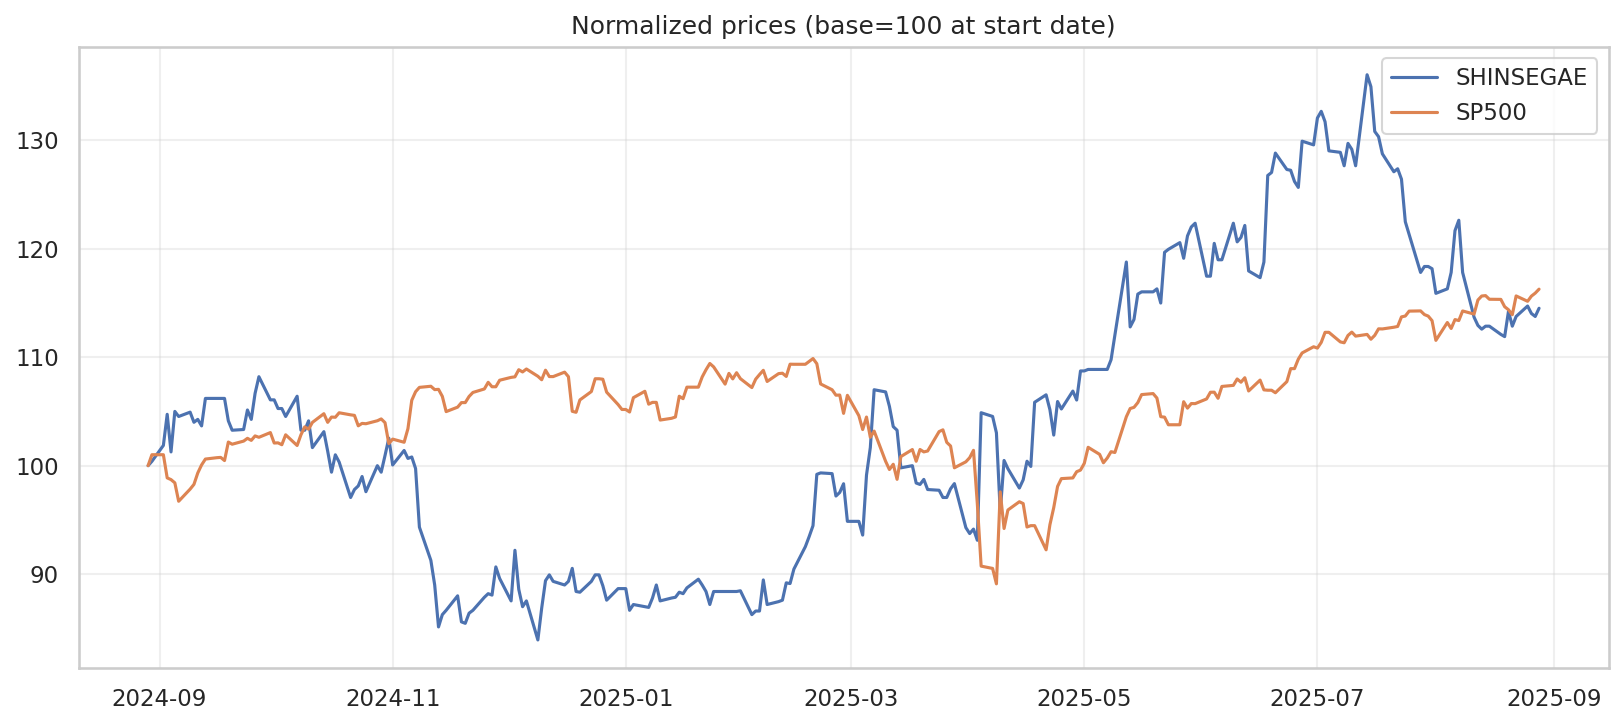

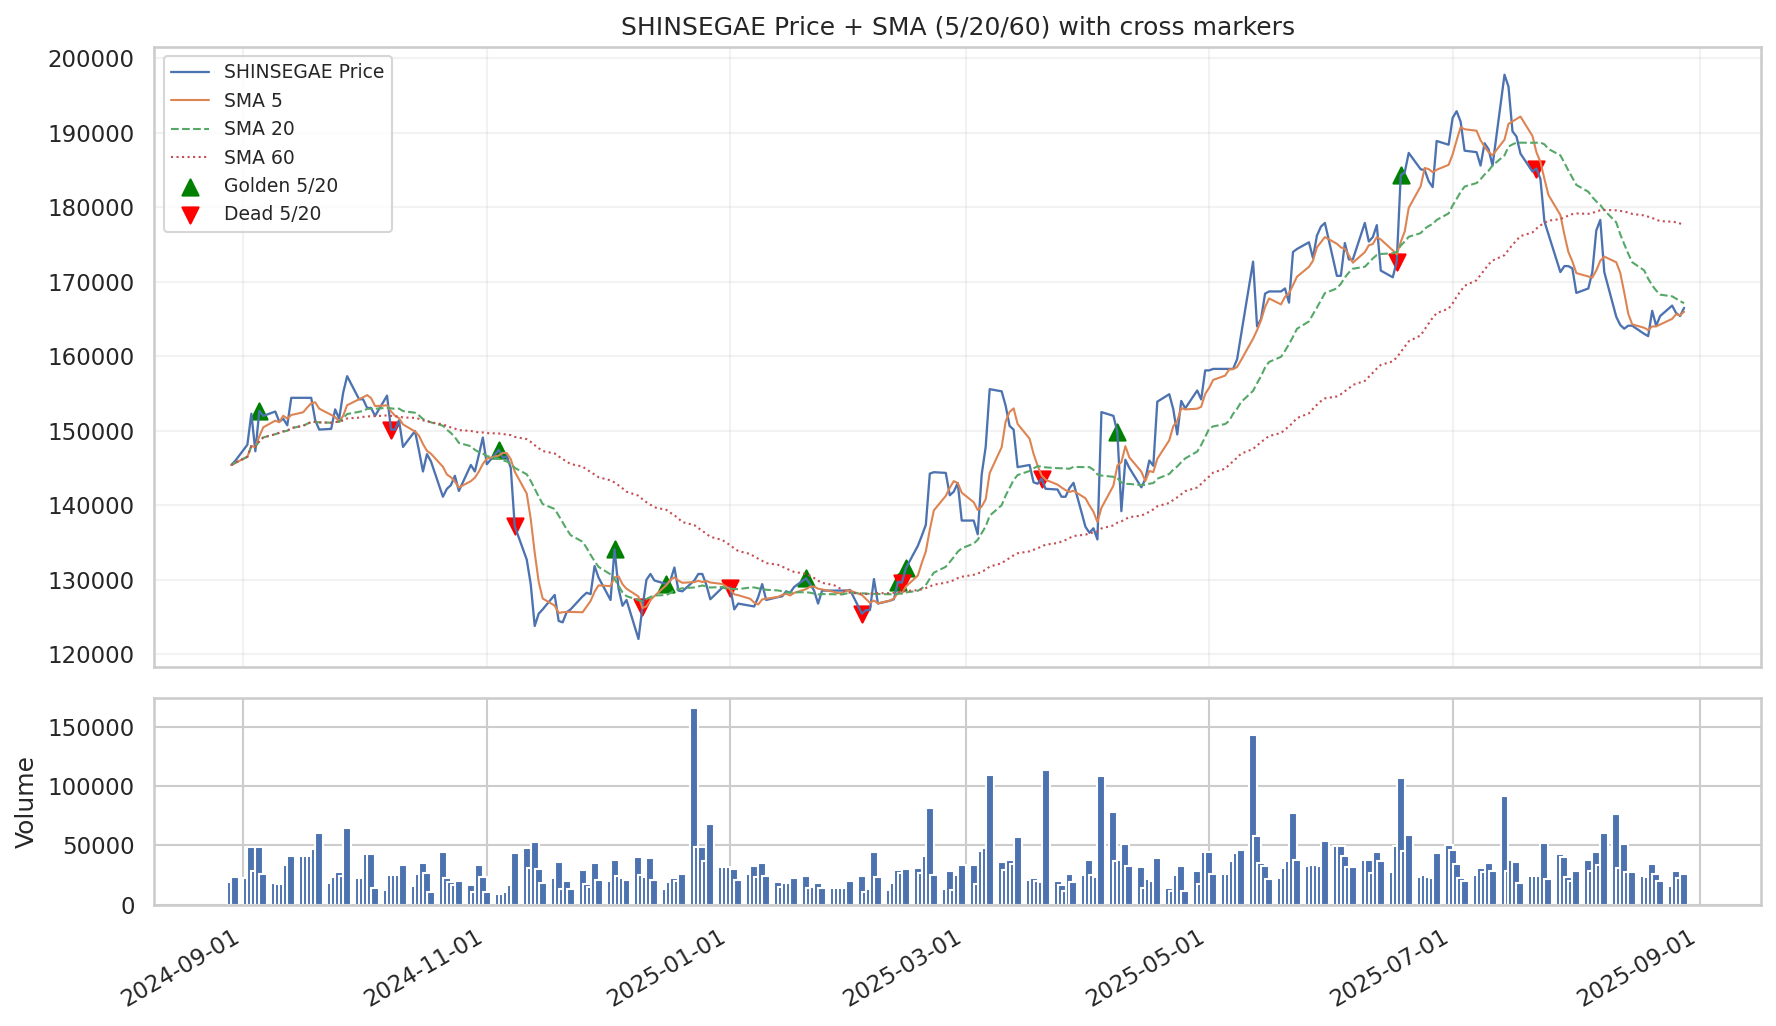

Last golden 5/20 crosses (most recent 5): [Timestamp('2025-01-20 00:00:00'), Timestamp('2025-02-12 00:00:00'), Timestamp('2025-02-14 00:00:00'), Timestamp('2025-04-08 00:00:00'), Timestamp('2025-06-18 00:00:00')]
Last dead 5/20 crosses (most recent 5): [Timestamp('2025-02-03 00:00:00'), Timestamp('2025-02-13 00:00:00'), Timestamp('2025-03-20 00:00:00'), Timestamp('2025-06-17 00:00:00'), Timestamp('2025-07-22 00:00:00')]


In [44]:
# 한 셀에 붙여넣고 실행 — inline으로 그래프 보여줌
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

DATA_DIR = "./data"
adj_path = os.path.join(DATA_DIR, "prices_adj.csv")
sma_path = os.path.join(DATA_DIR, "prices_with_sma.csv")
raw_stock_path = os.path.join(DATA_DIR, "SHINSEGAE_raw.csv")  # volume source if available

# 0) load data (either from memory or CSV)
try:
    df_sma  # if already in memory from earlier cell
except NameError:
    if os.path.exists(sma_path):
        df_sma = pd.read_csv(sma_path, index_col=0, parse_dates=True)
    else:
        # fallback: build sma from adj csv
        if os.path.exists(adj_path):
            adj_df = pd.read_csv(adj_path, index_col=0, parse_dates=True)
            df_sma = adj_df.copy()
            for col in adj_df.columns:
                for w in (5,20,60):
                    df_sma[f"{col}_SMA_{w}"] = adj_df[col].rolling(window=w, min_periods=1).mean()
        else:
            raise FileNotFoundError("No prices_with_sma.csv or prices_adj.csv found in ./data")

# ensure index is datetime
df_sma.index = pd.to_datetime(df_sma.index)

# load adj_df if needed for normalized plot
if 'adj_df' not in globals():
    if os.path.exists(adj_path):
        adj_df = pd.read_csv(adj_path, index_col=0, parse_dates=True)
        adj_df.index = pd.to_datetime(adj_df.index)
    else:
        # construct from df_sma (strip SMA cols)
        adj_cols = [c for c in df_sma.columns if not c.endswith(tuple(['_SMA_5','_SMA_20','_SMA_60']))]
        adj_df = df_sma[[c for c in df_sma.columns if not '_SMA_' in c]].copy()

# Try to load raw stock to get Volume
volume_series = None
if os.path.exists(raw_stock_path):
    try:
        raw_stock = pd.read_csv(raw_stock_path, index_col=0, parse_dates=True)
        # look for a 'Volume' column; if multi-level names, try to find any column containing 'Volume'
        candidate = None
        for c in raw_stock.columns:
            if 'volume' in str(c).lower():
                candidate = c
                break
        if candidate is not None:
            volume_series = raw_stock[candidate].astype(float).reindex(df_sma.index).ffill()
    except Exception as e:
        print("Could not read raw stock Volume:", e)

# ---------- Plot 1: Normalized comparison ----------
plt.figure(figsize=(11,5))
norm = adj_df / adj_df.iloc[0] * 100
for c in norm.columns:
    plt.plot(norm.index, norm[c], label=c)
plt.title("Normalized prices (base=100 at start date)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- Plot 2: SHINSEGAE price + SMA with cross markers ----------
stock = "SHINSEGAE"
if stock not in df_sma.columns:
    # try fallback: maybe column named differently, pick first non-SMA column
    non_sma = [c for c in df_sma.columns if not "_SMA_" in c]
    if len(non_sma) > 0:
        stock = non_sma[0]
    else:
        raise KeyError("No stock column found in df_sma")

dates = df_sma.index
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,7), gridspec_kw={"height_ratios":[3,1]}, sharex=True)

ax0.plot(dates, df_sma[stock], label=f"{stock} Price", linewidth=1.1)
for w, col_style in zip((5,20,60), ['-', '--', ':']):
    col_name = f"{stock}_SMA_{w}"
    if col_name in df_sma.columns:
        ax0.plot(dates, df_sma[col_name], label=f"SMA {w}", linestyle=col_style, linewidth=1.0)

# compute and mark 5/20 crosses (golden/dead)
def find_crosses(series_short, series_long):
    diff = series_short - series_long
    sign = np.sign(diff)
    golden = series_short.index[(sign > 0) & (sign.shift(1) <= 0)]
    dead   = series_short.index[(sign < 0) & (sign.shift(1) >= 0)]
    return list(golden), list(dead)

if f"{stock}_SMA_5" in df_sma.columns and f"{stock}_SMA_20" in df_sma.columns:
    g5, d5 = find_crosses(df_sma[f"{stock}_SMA_5"], df_sma[f"{stock}_SMA_20"])
    # plot markers
    ax0.scatter(g5, df_sma.loc[g5, stock], marker='^', color='green', s=60, label='Golden 5/20')
    ax0.scatter(d5, df_sma.loc[d5, stock], marker='v', color='red', s=60, label='Dead 5/20')
else:
    g5 = d5 = []

ax0.legend(loc='upper left', fontsize=9)
ax0.set_title(f"{stock} Price + SMA (5/20/60) with cross markers")
ax0.grid(alpha=0.25)

# volume plot if available
if volume_series is not None:
    ax1.bar(dates, volume_series.reindex(dates).fillna(0), width=2, align='center')
    ax1.set_ylabel("Volume")
else:
    ax1.text(0.5, 0.5, "No Volume data available", ha='center', va='center', transform=ax1.transAxes)
    ax1.set_ylabel("Volume")

ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# ---------- Optional: show the last few cross dates ----------
print("Last golden 5/20 crosses (most recent 5):", g5[-5:] if g5 else [])
print("Last dead 5/20 crosses (most recent 5):", d5[-5:] if d5 else [])


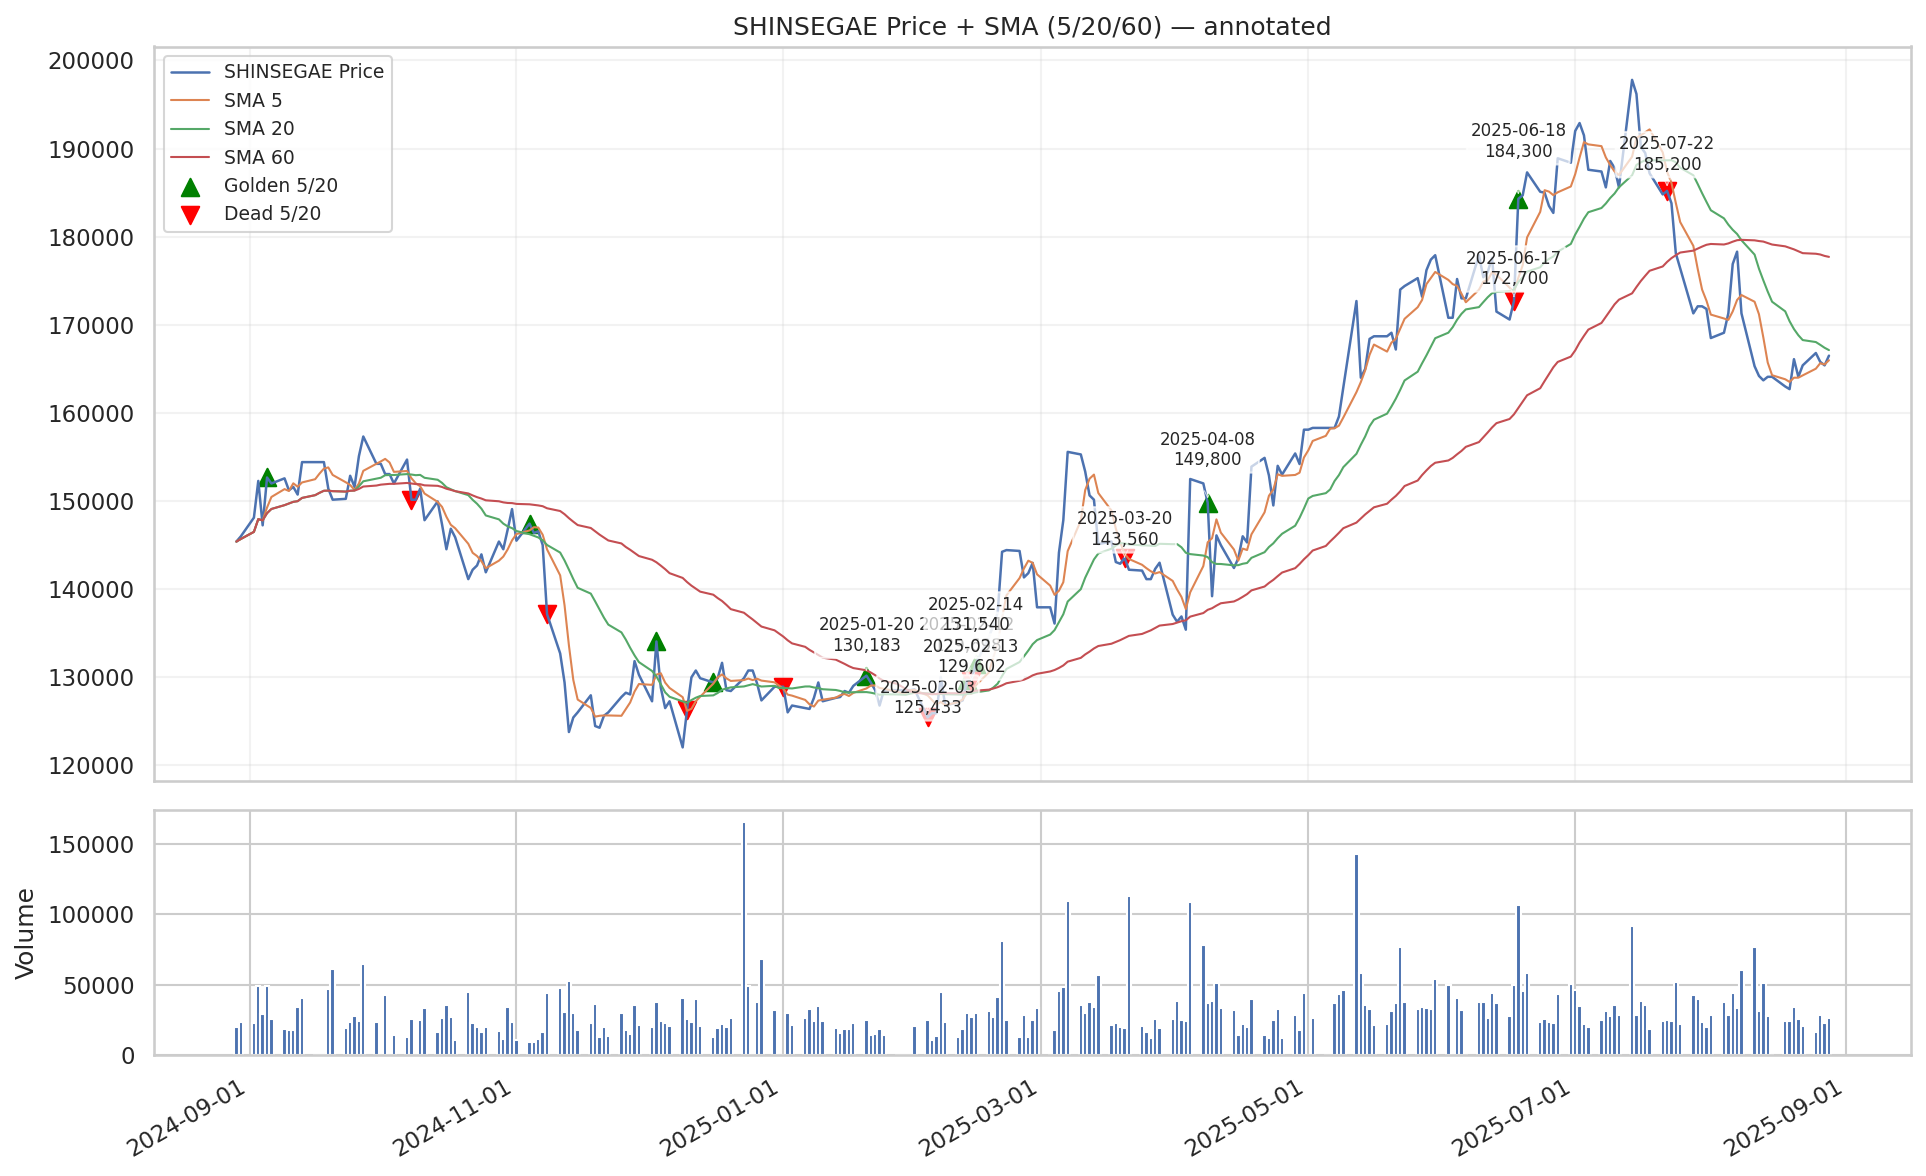

Saved annotated plot: ./data/SHINSEGAE_annotated_price_sma.png
Saved strategy perf CSV: ./data/SHINSEGAE_strategy_perf.csv


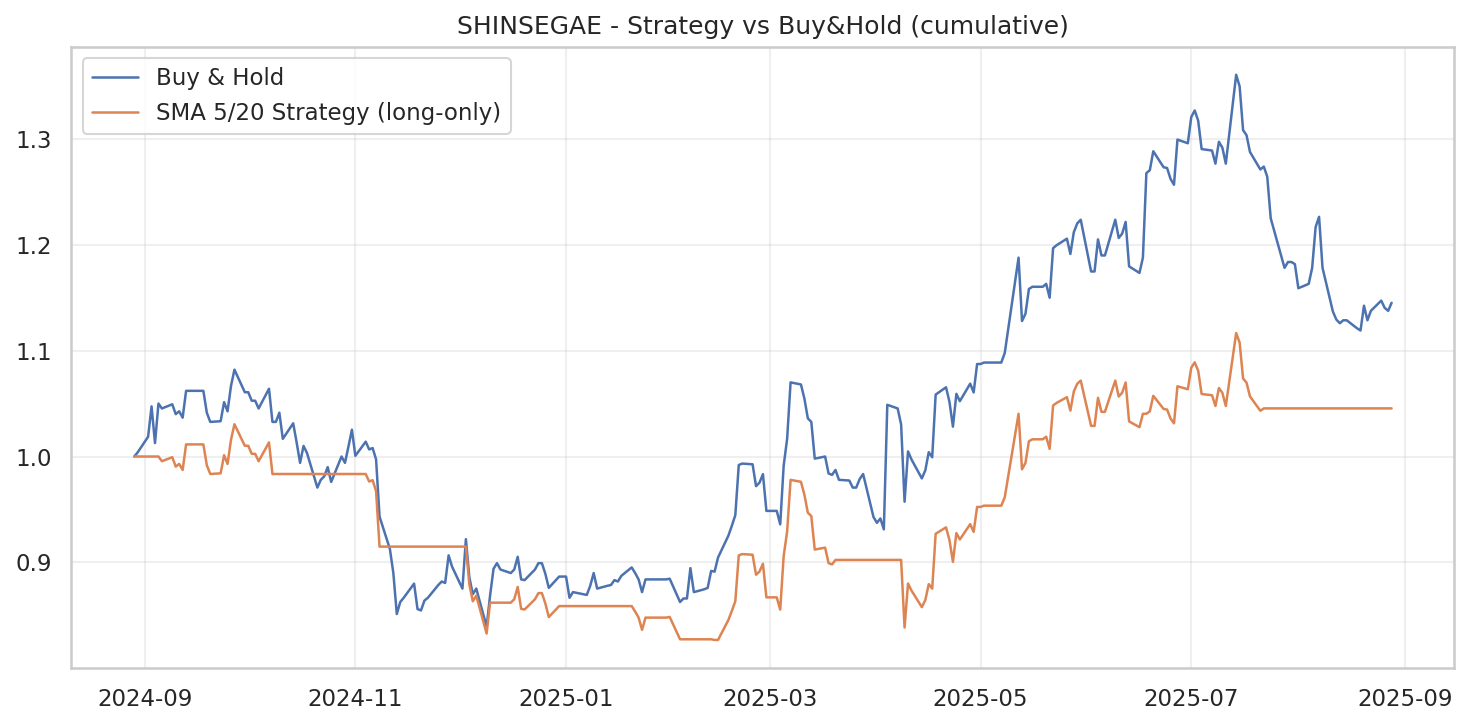

Saved equity curve: ./data/SHINSEGAE_strategy_vs_bh.png
Performance summary (approx):
 - buyhold_ann_return: 0.1398
 - strategy_ann_return: 0.0438
 - buyhold_ann_vol: 0.3384
 - strategy_ann_vol: 0.2521
 - buyhold_sharpe: 0.4130
 - strategy_sharpe: 0.1739


In [45]:
# === 추가 시각화 + 간단 전략 성과 (붙여넣고 실행) ===
%matplotlib inline
import os, math
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

DATA_DIR = "./data"
os.makedirs(DATA_DIR, exist_ok=True)

# 로드
sma_path = os.path.join(DATA_DIR, "prices_with_sma.csv")
adj_path = os.path.join(DATA_DIR, "prices_adj.csv")
raw_stock_path = os.path.join(DATA_DIR, "SHINSEGAE_raw.csv")

if os.path.exists(sma_path):
    df = pd.read_csv(sma_path, index_col=0, parse_dates=True)
else:
    df = pd.read_csv(adj_path, index_col=0, parse_dates=True)
    # make SMA columns if needed
    for c in df.columns:
        for w in (5,20,60):
            df[f"{c}_SMA_{w}"] = df[c].rolling(window=w, min_periods=1).mean()

# index 정리
df.index = pd.to_datetime(df.index)
stock = "SHINSEGAE"
if stock not in df.columns:
    # fallback: 첫 non-SMA 컬럼 사용
    non_sma = [c for c in df.columns if '_SMA_' not in c]
    stock = non_sma[0]

# (A) annotate crosses and save annotated PNG
def find_crosses(series_short, series_long):
    diff = series_short - series_long
    sign = np.sign(diff)
    golden = series_short.index[(sign > 0) & (sign.shift(1) <= 0)]
    dead   = series_short.index[(sign < 0) & (sign.shift(1) >= 0)]
    return list(golden), list(dead)

g5, d5 = find_crosses(df[f"{stock}_SMA_5"], df[f"{stock}_SMA_20"])

# create plot with annotations
fig, ax = plt.subplots(2,1, figsize=(13,8), gridspec_kw={"height_ratios":[3,1]}, sharex=True)
ax0, ax1 = ax
ax0.plot(df.index, df[stock], label=f"{stock} Price", linewidth=1.2)
ax0.plot(df.index, df[f"{stock}_SMA_5"], label="SMA 5", linewidth=1.0)
ax0.plot(df.index, df[f"{stock}_SMA_20"], label="SMA 20", linewidth=1.0)
ax0.plot(df.index, df[f"{stock}_SMA_60"], label="SMA 60", linewidth=1.0)
ax0.scatter(g5, df.loc[g5, stock], marker='^', color='green', s=70, label='Golden 5/20')
ax0.scatter(d5, df.loc[d5, stock], marker='v', color='red', s=70, label='Dead 5/20')

# annotate last few crosses with date+price
def annotate_points(ax, idxs, text_prefix="", ypos_offset=0):
    for t in idxs[-5:]:  # 마지막 5개만 표기(너무 많으면 지저분)
        price = df.loc[t, stock]
        ax.annotate(f"{t.date()}\n{price:,.0f}", xy=(t, price),
                    xytext=(0, 12 + ypos_offset), textcoords='offset points',
                    ha='center', fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7),
                    arrowprops=dict(arrowstyle="->", lw=0.5, alpha=0.7))
        ypos_offset += 2

annotate_points(ax0, g5, "G", 0)
annotate_points(ax0, d5, "D", -10)

ax0.set_title(f"{stock} Price + SMA (5/20/60) — annotated")
ax0.legend(loc='upper left', fontsize=9)
ax0.grid(alpha=0.25)

# show volume if available in raw stock csv
vol = None
if os.path.exists(raw_stock_path):
    raw = pd.read_csv(raw_stock_path, index_col=0, parse_dates=True)
    # find a volume column
    vol_col = None
    for c in raw.columns:
        if 'volume' in str(c).lower():
            vol_col = c; break
    if vol_col is not None:
        vol = raw[vol_col].reindex(df.index).fillna(0)

if vol is not None:
    ax1.bar(df.index, vol, width=1.0, align='center')
    ax1.set_ylabel("Volume")
else:
    ax1.text(0.5, 0.5, "Volume not available", transform=ax1.transAxes, ha='center')
    ax1.set_ylabel("Volume")

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate()
plt.tight_layout()
annot_png = os.path.join(DATA_DIR, f"{stock}_annotated_price_sma.png")
plt.savefig(annot_png, dpi=300)
plt.show()
print("Saved annotated plot:", annot_png)


# (B) 간단 SMA 전략 성과: 5/20 골든이면 롱, 데드면 현금(또는 숏 아님)
price = df[stock].copy()
signal = (df[f"{stock}_SMA_5"] > df[f"{stock}_SMA_20"]).astype(int)  # 1 = long, 0 = cash
# shift signal so we trade at next day open (here approximate with next-day returns)
returns = price.pct_change().fillna(0)
strategy_ret = signal.shift(1).fillna(0) * returns  # apply previous day signal to today's return
cum_strategy = (1 + strategy_ret).cumprod()
cum_bh = (1 + returns).cumprod()

# save strategy results
perf_df = pd.DataFrame({
    "price": price,
    "signal": signal,
    "daily_return": returns,
    "strategy_return": strategy_ret,
    "cum_strategy": cum_strategy,
    "cum_buyhold": cum_bh
})
perf_csv = os.path.join(DATA_DIR, f"{stock}_strategy_perf.csv")
perf_df.to_csv(perf_csv)
print("Saved strategy perf CSV:", perf_csv)

# plot equity curves
plt.figure(figsize=(10,5))
plt.plot(perf_df.index, perf_df["cum_buyhold"], label="Buy & Hold", linewidth=1.2)
plt.plot(perf_df.index, perf_df["cum_strategy"], label="SMA 5/20 Strategy (long-only)", linewidth=1.2)
plt.title(f"{stock} - Strategy vs Buy&Hold (cumulative)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
eq_png = os.path.join(DATA_DIR, f"{stock}_strategy_vs_bh.png")
plt.savefig(eq_png, dpi=300)
plt.show()
print("Saved equity curve:", eq_png)

# (C) 간단한 성과 지표(연환산 수익률, 연환산 변동성, 샤프)
def annualize_return(cum_series):
    total_periods = len(cum_series)
    if total_periods <= 1:
        return np.nan
    total_ret = cum_series.iloc[-1] - 1.0
    years = total_periods / 252.0
    return (1 + total_ret) ** (1/years) - 1

def annualized_vol(daily_returns):
    return daily_returns.std() * np.sqrt(252)

ann_ret_bh = annualize_return(cum_bh)
ann_ret_strat = annualize_return(cum_strategy)
ann_vol_bh = annualized_vol(returns)
ann_vol_strat = annualized_vol(strategy_ret)
sharpe_bh = ann_ret_bh / ann_vol_bh if ann_vol_bh>0 else np.nan
sharpe_strat = ann_ret_strat / ann_vol_strat if ann_vol_strat>0 else np.nan

stats = {
    "buyhold_ann_return": ann_ret_bh,
    "strategy_ann_return": ann_ret_strat,
    "buyhold_ann_vol": ann_vol_bh,
    "strategy_ann_vol": ann_vol_strat,
    "buyhold_sharpe": sharpe_bh,
    "strategy_sharpe": sharpe_strat
}
print("Performance summary (approx):")
for k,v in stats.items():
    print(f" - {k}: {v:.4f}" if (isinstance(v, float) and not math.isnan(v)) else f" - {k}: {v}")

# 끝


In [46]:
# 실행해서 정확한 성과 지표 출력하기 (복사→새 셀→실행)
import pandas as pd, numpy as np, os, math

perf_csv = "./data/SHINSEGAE_strategy_perf.csv"   # 이전에 저장한 파일
if not os.path.exists(perf_csv):
    raise FileNotFoundError(perf_csv + " not found. Run the strategy cell first.")

perf = pd.read_csv(perf_csv, index_col=0, parse_dates=True)
# final cumulative values
final_bh = perf["cum_buyhold"].iloc[-1]
final_strat = perf["cum_strategy"].iloc[-1]
# annualize helpers
def ann_return_from_cum(cum_series):
    total_periods = len(cum_series)
    years = total_periods / 252.0
    if years <= 0: return np.nan
    return cum_series.iloc[-1] ** (1/years) - 1

def ann_vol(daily_ret):
    return daily_ret.std() * np.sqrt(252)

ann_ret_bh = ann_return_from_cum(perf["cum_buyhold"])
ann_ret_strat = ann_return_from_cum(perf["cum_strategy"])
ann_vol_bh = ann_vol(perf["daily_return"])
ann_vol_strat = ann_vol(perf["strategy_return"])
sharpe_bh = ann_ret_bh / ann_vol_bh if ann_vol_bh>0 else np.nan
sharpe_strat = ann_ret_strat / ann_vol_strat if ann_vol_strat>0 else np.nan

print("Final cumulative (Buy&Hold):", final_bh)
print("Final cumulative (Strategy):", final_strat)
print()
print("Annualized return - BH: {:.4%}, Strat: {:.4%}".format(ann_ret_bh, ann_ret_strat))
print("Annualized vol    - BH: {:.4%}, Strat: {:.4%}".format(ann_vol_bh, ann_vol_strat))
print("Sharpe (approx)   - BH: {:.4f}, Strat: {:.4f}".format(sharpe_bh, sharpe_strat))


Final cumulative (Buy&Hold): 1.1451019061175498
Final cumulative (Strategy): 1.0454316822023657

Annualized return - BH: 13.9764%, Strat: 4.3831%
Annualized vol    - BH: 33.8387%, Strat: 25.2088%
Sharpe (approx)   - BH: 0.4130, Strat: 0.1739
